# Assignment 8: Correlation Analysis and Hypothesis Testing

## Objective

The field of statistics is divided into two major parts: descriptive and inferential. In this assignment, we will cover two important topics in statistics: correlation analysis and hypothesis testing, where the former belongs to the descriptive part and the latter belongs to the inferential part. After this assignment, you will be able to answer the following questions:

**Correlation Analysis**
1. How to visualize the relationship between two variables?  
2. What is Pearson's correlation? How to compute it?
3. What is Spearman's rank correlation? How to compute it?
4. What's the difference between Pearson's correlation and Spearman's rank correlation? 


**Hypothesis Testing**
1. Why A/B testing?  
2. What is a permutation test? How to implement it?
3. What is p-value? How to avoid p-hacking? 
4. What is a chi-squared test? How to implement it?


In this assignment, you can use [pandas](https://pandas.pydata.org/) or PySpark to manipulate data, and use [matplotlib](https://matplotlib.org/) or [seaborn](seaborn.pydata.org) to make plots. 

## Part 1. Correlation Analysis

As a data scientist, you often face this kind of question: "Are A and B correlated?" For example, 

* Do Canadian Currency and Oil Price move together?
* Do Vancouver Housing Price and US Stock Market have any correlation?
* Are GPA and Gender independent? 

To answer these questions, you need to conduct correlation analysis. 

Imagine you are a data scientist working at a real-estate company. You download a dataset from [property_tax_report_2018.zip](property_tax_report_2018.zip). The dataset contains information on properties from BC Assessment (BCA) and City sources in 2018.  You can find the schema information of the dataset from this [webpage](http://data.vancouver.ca/datacatalogue/propertyTaxAttributes.htm). 

You may think that for a newly built house, it tends to have a higher price than the ones built decades ago. In this assignment, your first job is to figure out whether YEAR_BUILT and HOUSE_PRICE are correlated. 

We first load the data as a DataFrame. 

In [2]:
import pandas as pd

df = pd.read_csv("property_tax_report_2018.csv")

df['HOUSE_PRICE'] = df.apply(lambda x: (x['CURRENT_LAND_VALUE']+x['CURRENT_IMPROVEMENT_VALUE'])/1000000.0, axis = 1)

### Task A. Visualizations

Since the housing price varies a lot by locations, we will only consider the houses whose <font color='blue'>postcode starts with 'V6A'</font>. Furthermore, we remove the houses that were <font color='blue'>built before 1900</font>.

In [64]:
df = df[df['PROPERTY_POSTAL_CODE'].str.startswith("V6A") == True]
df = df[(df.YEAR_BUILT >= 1900)]
df.shape

(4726, 29)

<img src="img/v6a.png", width=500/>

In the following, please make two subplots in one row. For the left subplot, it is a scatter plot with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`; for the right subplot, it is a hexbin plot (gridsize = 20) with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`.

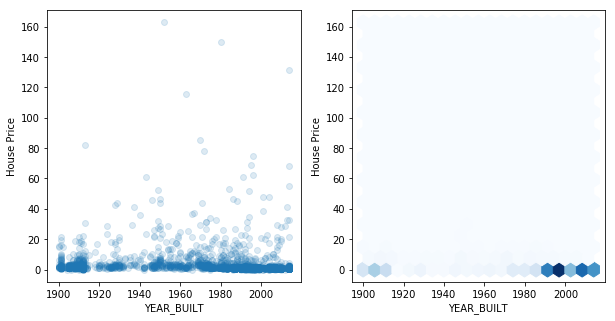

In [59]:
#<-- Write Your Code -->
from matplotlib import pyplot as plt
%matplotlib inline

f, (p1, p2) = plt.subplots(1,2, figsize=(10,5))

p1.scatter(data.YEAR_BUILT, data.HOUSE_PRICE, alpha= 0.15)
p1.set_xlabel('YEAR_BUILT');
p1.set_ylabel('House Price');

p2.hexbin(data.YEAR_BUILT, data.HOUSE_PRICE, gridsize = 20, cmap=plt.cm.Blues)
p2.set_xlabel('YEAR_BUILT');
p2.set_ylabel('House Price');


Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. Fig 1: We can see some general trends in pricing which remains stable for most of the years. But there are some noticable gaps in the dark blue clusters just before 1920 and 1940 thats stands out. 
2. Fig 2: The dark blue hexa bins near 2000 tells that most of the data cluttered near that period.

The above plots provide a general impression of the relationship between variables. There are some other visualizations that can provide more insight. One option is to bin one variable and plot percentiles of the other. 


In the following, please make three subplots in a row, where each subplot is a scatter plot with X = YEAR_BUILT and Y = HOUSE_PRICE. 
* The first subplot shows how the 25th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `25TH_HOUSE_PRICE`); 
* The second subplot shows how the 50th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `50TH_HOUSE_PRICE`); 
* The third subplot shows how the 75th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `75TH_HOUSE_PRICE`);  


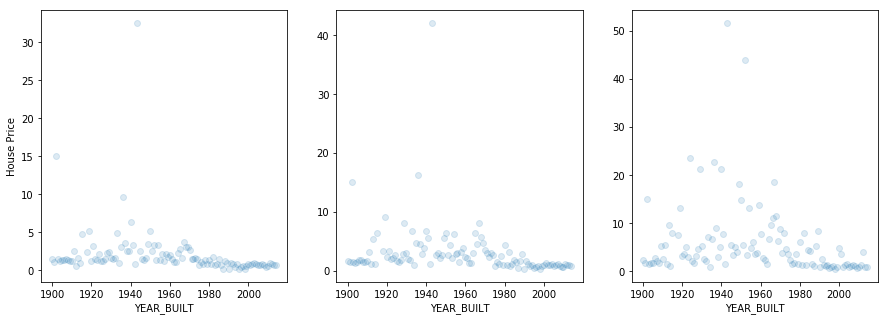

In [126]:
#<-- Write Your Code -->
from matplotlib import pyplot as plt
%matplotlib inline


f, (p1, p2, p3) = plt.subplots(1,3, figsize=(15,5))

data = df[['YEAR_BUILT','HOUSE_PRICE']]

data_25 = data.groupby('YEAR_BUILT').quantile(.25)
data_25.columns = [ 'HOUSE_PRICE']
data_25['YEAR_BUILT'] = data_25.index

data_50 = data.groupby('YEAR_BUILT').quantile() # default .50 == median
data_50.columns = [ 'HOUSE_PRICE']
data_50['YEAR_BUILT'] = data_50.index

data_75 = data.groupby('YEAR_BUILT').quantile(.75)
data_75.columns = [ 'HOUSE_PRICE']
data_75['YEAR_BUILT'] = data_75.index

p1.scatter(data_25.index, data_25.HOUSE_PRICE, alpha= 0.15)
p1.set_xlabel('YEAR_BUILT');
p1.set_ylabel('House Price');

p2.scatter(data_50.index, data_50.HOUSE_PRICE, alpha= 0.15)
p2.set_xlabel('YEAR_BUILT');
# p2.set_ylabel('House Price');

p3.scatter(data_75.index, data_75.HOUSE_PRICE, alpha= 0.15)
p3.set_xlabel('YEAR_BUILT');
# p3.set_ylabel('House Price');


Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. The 25th and 50th percentile plots follows a similar pattern; whereas its lot non-compressed scatter points for 75th percentile.
2. For 75th percentile plot, we can see there's an year close to 2010 or so when the 75th percentile price was way higher than the general trend for the year [2000 and up]. I wonder what caaused the outlier there.

### Task B. Correlation Coefficient

A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between a pair of variables. 

In the following, please compute the Pearson's correlation as well as Spearman's rank correlation for three pairs of variables: <`25TH_HOUSE_PRICE`, `YEAR_BUILT`>, <`50TH_HOUSE_PRICE`, `YEAR_BUILT`>, and <`75TH_HOUSE_PRICE`, `YEAR_BUILT`>, and then print out your results. 

Note that it is OK to use this [function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) to do this task, but make sure that you understand how the numbers are computed. 

In [140]:
#<-- Write Your Code -->
def getCorr(result_df):
    return(result_df.at['HOUSE_PRICE','YEAR_BUILT'])

print('25th Percentile (pearson, spearman): {}, {}'.format(getCorr(data_25.corr()), getCorr(data_25.corr(method = 'spearman'))))
print('50th Percentile (pearson, spearman): {}, {}'.format(getCorr(data_50.corr()), getCorr(data_50.corr(method = 'spearman'))))
print('75th Percentile (pearson, spearman): {}, {}'.format(getCorr(data_75.corr()), getCorr(data_75.corr(method = 'spearman'))))


25th Percentile (pearson, spearman): -0.24453312810700037, -0.5721119349437933
50th Percentile (pearson, spearman): -0.23750401421800116, -0.5098468832130557
75th Percentile (pearson, spearman): -0.21267690503199596, -0.4004424778761062


Please write down the **two** most interesting findings that you draw from the result. 

**Findings**
1. Both spearman & pearson shows negative correlationship between 2 variables.
2. The relative changes among Person's correlation values (1st col) is lower than the relative changes among Spearman's correlation (2nd col) numbers. 

## Part 2. Hypothesis Testing

In many situations, we cannot get the full population but only a sample. If we derive an interesting result from a sample, how likely can we derive the same result from the entire population? In other words, we want to know whether this result is a true finding or it just happens in the sample by chance. Hypothesis testing aims to answer this fundamental question. 

### Task C. A/B Testing
> Acknowledgment: Thank [Greg Baker](http://www.cs.sfu.ca/~ggbaker/) for helping me to prepare this task.

A very common technique to evaluate changes in a user interface is A/B testing: show some users interface A, some interface B, and then look to see if one performs better than the other.

Suppose I started an A/B test on CourSys. Here are the two interfaces that I want to compare with. I want to know whether a good placeholder in the search box can attract more users to use the `search` feature.

<img src="img/ab-testing.png", width=800/>

The provided [searchlog.json](./searchlog.json) has information about users' usage. The question I was interested in: do people search more with the new design? (More precisely: is the number of searches per user different?)

To answer this question, we need to first pick up a **test statistic** to quantify how good an interface is. Here, we choose "the search_count mean". 

Please write the code to compute **the difference of the search_count means between interface A and Interface B.** 

In [95]:
#<-- Write Your Code -->
import json

data_a = []
data_b = []
with open('searchlog.json') as f:
    for line in f:
        json_row = json.loads(line)
        if(json_row['search_ui'] == 'A'):
            data_a.append(json_row)
        else:
            data_b.append(json_row)

mean_a = float(sum(d['search_count'] for d in data_a)) / len(data_a)
mean_b = float(sum(d['search_count'] for d in data_b)) / len(data_b)

print(mean_b - mean_a)

0.13500569535052287


Suppose we find that the mean value increased by 0.135. Then, we wonder whether this result is just caused by random variation. 

We define the Null Hypothesis as
 * The difference in search_count mean between Interface A and Interface B is caused by random variation. 
 
Then the next job is to check whether we can reject the null hypothesis or not. If it does, we can adopt the alternative explanation:
 * The difference in search_count mean  between Interface A and Interface B is caused by the design differences between the two.

We compute the p-value of the observed result. If p-value is low (e.g., <0.01), we can reject the null hypothesis, and adopt  the alternative explanation.  

Please implement a permutation test (numSamples = 10000) to compute the p-value. Note that you are NOT allowed to use an implementation in an existing library. You have to implement it by yourself.

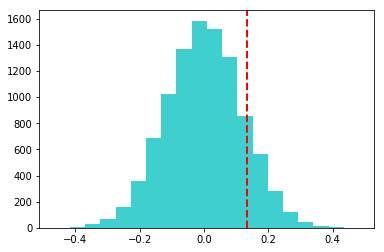

In [99]:
#<-- Write Your Code -->
from matplotlib import pyplot as plt
%matplotlib inline

from random import shuffle
import json

# data preparation
data_a = []
data_b = []
search_count_list = []
row_no = 0
with open('searchlog.json') as f:
    for line in f:
        json_row = json.loads(line)
        if(json_row['search_ui'] == 'A'):
            data_a.append(row_no)
        else:
            data_b.append(row_no)
        search_count_list.append(json_row['search_count'])
        row_no = row_no + 1

# generating mean differences 1000 times
mean_diffs = []

for _ in range(10000):
    shuffle(search_count_list)
    a_s = [search_count_list[i] for i in data_a]
    b_s = [search_count_list[i] for i in data_b]
    mean_a = float(sum(a_s)/len(a_s))
    mean_b = float(sum(b_s)/len(b_s))
    mean_diffs.append(mean_a - mean_b)


plt.hist(mean_diffs, 20, color='c', alpha=0.75)
plt.axvline(0.13500569535052287, color='red', linestyle='dashed', linewidth=2)



In [100]:
import numpy as np

def pvalue(observed_value, trials, bins = 10):
    x = np.histogram(trials, bins= bins)
    bin_no = 0
    for upperbound in x[1]:
        if (upperbound >= observed_value):
            # found my bin
            return(sum(x[0][bin_no:])/sum(x[0]))
            break
        bin_no = bin_no +1
    return(0)

pvalue(0.13500569535052287, mean_diffs, bins= 20)
    

0.1032

Suppose we want to use the same dataset to do another A/B testing. We suspect that instructors are the ones who can get more useful information from the search feature, so perhaps non-instructors didn't touch the search feature because it was genuinely not relevant to them.

So we decide to repeat the above analysis looking only at instructors.

**Q. If using the same dataset to do this analysis, do you feel like we're p-hacking? If so, what can we do with it? **

**A.** We should not use the same dataset. What if the dataset is biassed for instructors, that is we intentionally/accidentally collected more data from instructors than non instructors. Ideally, We should test this using an entirely new sample. Or at the least, we should run some hypothesis testing method to accept/reject our null hypothesis (if we don't have anymore independent datasets). Like we are doing in section D

### Task D. Chi-squared test 

There are tens of different hypothesis testing methods. It's impossible to cover all of them in one week. Given that this is an important topic in statistics, I highly recommend using your free time to learn some other popular ones such as <a href="https://en.wikipedia.org/wiki/Chi-squared_test">Chi-Squired test</a>, <a href = "https://en.wikipedia.org/wiki/G-test">G-test</a>, <a href="https://en.wikipedia.org/wiki/Student%27s_t-test">T-test</a>, and <a href="https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test">Mann–Whitney U test</a>.

On the searchlog dataset, there are two categorical columns: `is_instructor` and `search_ui`. In Task D, your job is to first learn how a Chi-Squired test works by yourself and then use it to test whether `is_instructor` and `search_ui` are correlated. 

Please write code to compute the contingency table, the chi-squared stat, the degrees of freedom, and the p-value. Note that unlike Task C, you can call any function in an existing library. But, please make sure to understand how those functions are implemented. 

In [147]:
# calculate spearmans
# ref: https://www.youtube.com/watch?v=XYMy6_8Cynk
import json
import pandas as pd

data_a = []
data_b = []
data = []
with open('searchlog.json') as f:
    for line in f:
        json_row = json.loads(line)
        data.append(json_row)

instructors = [d['is_instructor'] for d in data]
searchui = [d['search_ui'] for d in data]


df = pd.DataFrame(np.column_stack([instructors, searchui]), 
                               columns=['instructor', 'search'])
x,y = stats.spearmanr(instructors, searchui)
# print(x)

table = pd.crosstab(df['instructor'], df['search'])

print('Contingency table::')
print(table)

chi2, p, dof, expected = stats.chi2_contingency(table)
print ('\n\np value: ', p )
print('chi square test: ', chi2)
print('degrees of freedom: ', dof)

Contingency table::
search        A    B
instructor          
False       233  213
True        115  120


p value:  0.459393799574
chi square test:  0.547371235622
degrees of freedom:  1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


So sincec p-value is greater than 1% we can reject our hull hypothesis.

## Submission

Complete Tasks A-D in this [notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A8/A8.ipynb), and submit it to the CourSys activity Assignment 8.